In [21]:
from collections import defaultdict

import matplotlib.pyplot as plt
# 常用包
import numpy as np
import pandas as pd
import seaborn as sns
# 导入torch
import torch
import torch.nn.functional as F
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# 导入transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [22]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
torch.cuda.is_available()

True

In [24]:
with open('data/train_dataset_v2.tsv', 'r', encoding='utf-8') as handler:
    lines = handler.read().split('\n')[1:-1]

    data = list()
    for line in tqdm(lines):
        sp = line.split('\t')
        if len(sp) != 4:
            print("ERROR:", sp)
            continue
        data.append(sp)

train = pd.DataFrame(data)
train.columns = ['id', 'content', 'character', 'emotions']

test = pd.read_csv('data/test_dataset.tsv', sep='\t')
submit = pd.read_csv('data/submit_example.tsv', sep='\t')
train = train[train['emotions'] != '']

100%|██████████| 42790/42790 [00:00<00:00, 310625.73it/s]


In [25]:
def get_context(df, cur_id):
    pos = cur_id.split('_')[-1]
    # print(pos)
    pos_str = str(int(pos) - 1)

    location = train['id'][0][:-2] + '_' + pos_str
    #print(location)
    ret = train.loc[train['id'] == location]['content'].values.tolist()
    if len(ret) == 1:
        return ret[0]
    else:
        return "无上文"
print(get_context(train, '1171_0001_A_1'))

无上文


In [26]:
train['character'].fillna('无角色', inplace=True)
test['character'].fillna('无角色', inplace=True)

train['text'] = train['content'].astype(str)  +'角色: ' + train['character'].astype(str)
test['text'] = test['content'].astype(str) + ' 角色: ' + test['character'].astype(str)

In [27]:
# add train context info
for i in range(len(train['text'])):
    try:
        lcw = get_context(train, train['id'][i])
    except:
        continue
    train['text'][i] += ' 上文: ' + lcw
train.head()

,id,content,character,emotions,text
0,1171_0001_A_1,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,o2,"0,0,0,0,0,0",天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o...
1,1171_0001_A_2,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,c1,"0,0,0,0,0,0",天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: c...
2,1171_0001_A_3,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,o2,"0,0,0,0,0,0",o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: o2 上文: 天空下着暴雨，...
3,1171_0001_A_4,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,c1,"0,0,0,0,0,0",o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: c1 上文: o2一手拿着一...
4,1171_0001_A_5,o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...,o2,"0,0,0,0,0,0",o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...


In [28]:
# add test context info
for i in range(len(test['id'])):
    try:
        lcw = get_context(test, test['id'][i])
    except:
        continue
    test['text'][i] += ' 上文: ' + lcw
test.head()

,id,content,character,text
0,34170_0002_A_12,穿着背心的b1醒来，看看手机，三点了。,b1,穿着背心的b1醒来，看看手机，三点了。 角色: b1 上文: o2笑了笑：军礼不是这么敬的。...
1,34170_0002_A_14,b1走出卧室。,b1,b1走出卧室。 角色: b1 上文: o2示范了一个动作，c1照做。
2,34170_0003_A_16,b1拿着手机，点开计时功能。,b1,b1拿着手机，点开计时功能。 角色: b1 上文: c1照做。
3,34170_0003_A_17,b1站在淋浴头下面，水从b1的头和脸上冲刷而过。,b1,b1站在淋浴头下面，水从b1的头和脸上冲刷而过。 角色: b1 上文: b1画外音：我叫b1...
4,34170_0003_A_18,b1摈着呼吸。,b1,b1摈着呼吸。 角色: b1 上文: 无上文


In [29]:
train['emotions'] = train['emotions'].apply(lambda x: [int(_i) for _i in x.split(',')])
# train[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] = train['emotions'].values.tolist()

In [67]:
test['emotions'] = test['content'].copy()
for i in range(len(test['emotions'])):
    test['emotions'][i] = [0, 0, 0, 0, 0, 0]

In [30]:
train['text'].head()
train['text'][0]

'天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o2 上文: 无上文'

In [31]:
PRE_TRAINED_MODEL_NAME = 'chinese-roberta-wwm-ext'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
token_lens = []

for txt in tqdm(train.text):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 36782/36782 [00:12<00:00, 2878.26it/s]


/home/tiger/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


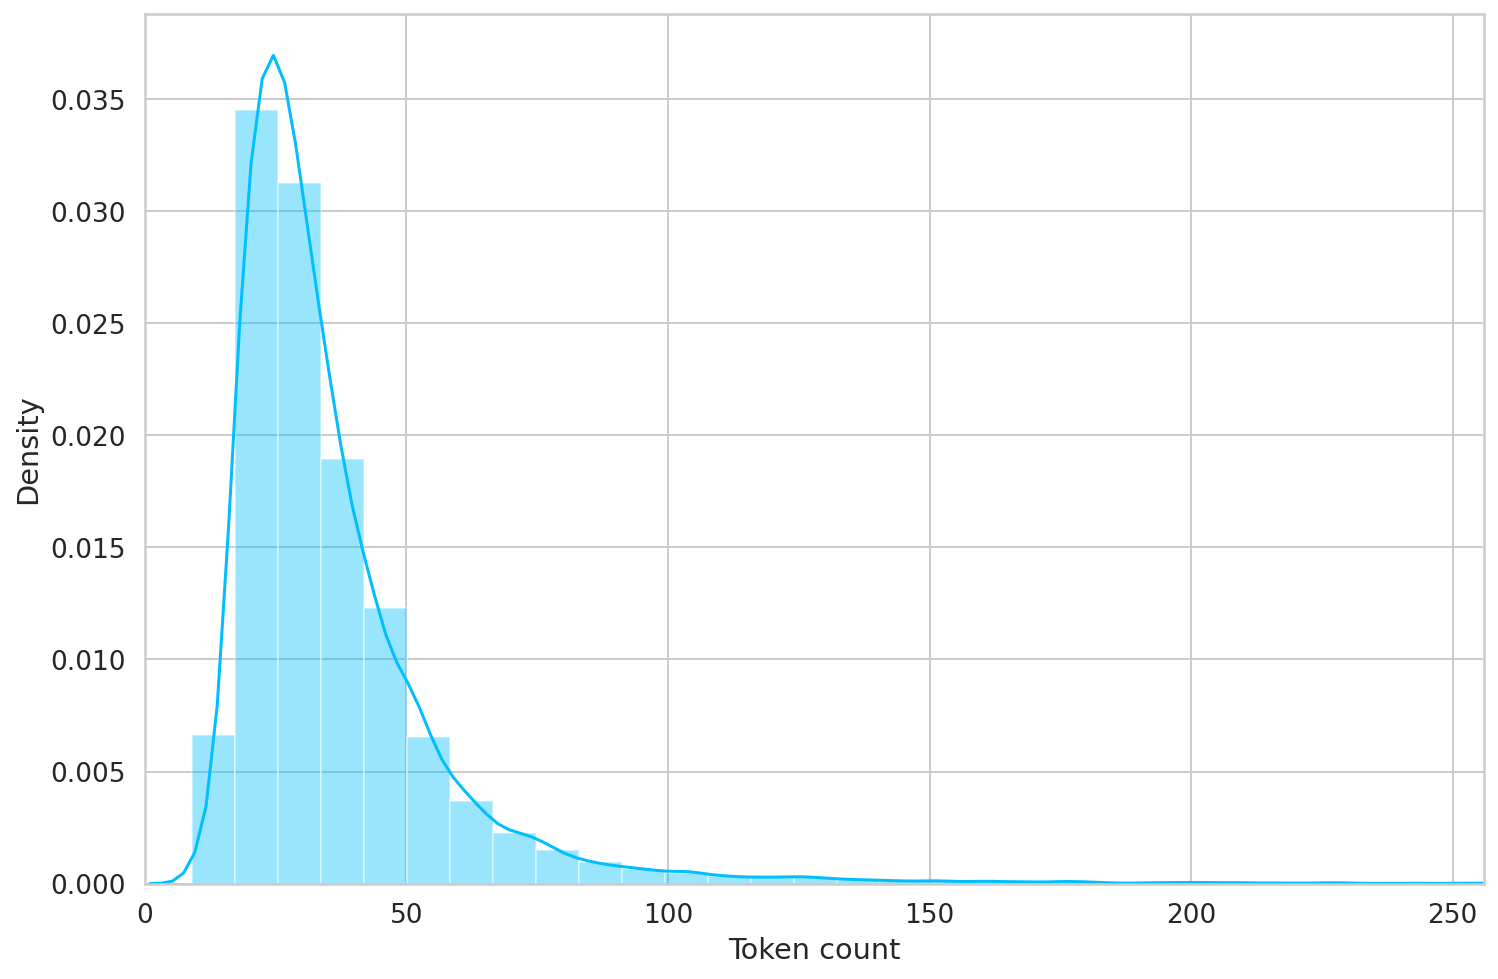

In [33]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [34]:
pd.Series(token_lens).describe()

count    36782.000000
mean        35.921184
std         21.946276
min          9.000000
25%         23.000000
50%         30.000000
75%         41.000000
max        420.000000
dtype: float64

In [51]:
MAX_LEN=128 # 这里我们暂时选定128

In [36]:
target_cols=['emotions']

In [37]:
class RoleDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        sample = {
            'texts': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        for label_col in target_cols:
            sample[label_col] = torch.tensor(label[label_col], dtype=torch.float)
        return sample
        

In [38]:
df_train, df_val = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)

In [39]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=RoleDataset(
        texts=df['text'].values,
        labels=df[target_cols].to_dict('records'),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
    )

In [40]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [41]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['texts', 'input_ids', 'attention_mask', 'emotions'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['emotions'].shape)

torch.Size([16, 350])
torch.Size([16, 350])
torch.Size([16, 6])


In [43]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# class EmotionClassifier(nn.Module):
#     def __init__(self, n_classes):
#         super(EmotionClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#         self.out_love = nn.Linear(self.bert.config.hidden_size, n_classes)
#         self.out_joy = nn.Linear(self.bert.config.hidden_size, n_classes)
#         self.out_fright = nn.Linear(self.bert.config.hidden_size, n_classes)
#         self.out_anger = nn.Linear(self.bert.config.hidden_size, n_classes)
#         self.out_fear = nn.Linear(self.bert.config.hidden_size, n_classes)
#         self.out_sorrow = nn.Linear(self.bert.config.hidden_size, n_classes)
#     def forward(self, input_ids, attention_mask):
#         _, pooled_output = self.bert(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             return_dict = False
#         )
#         love = self.out_love(pooled_output)
#         joy = self.out_joy(pooled_output)
#         fright = self.out_fright(pooled_output)
#         anger = self.out_anger(pooled_output)
#         fear = self.out_fear(pooled_output)
#         sorrow = self.out_sorrow(pooled_output)
#         return {
#             'love': love, 'joy': joy, 'fright': fright,
#             'anger': anger, 'fear': fear, 'sorrow': sorrow,
#         }

In [44]:
class EmotionRegression(nn.Module):
    def __init__(self, n_classes):
        super(EmotionRegression, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        out = self.out(pooled_output)
        return out

In [45]:
# class_names=train.love.unique()
# class_names=[1]

In [46]:
model = EmotionRegression(6)
model = model.to(device)

Some weights of the model checkpoint at chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
EPOCHS = 3 # 训练轮数

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)

In [48]:
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for sample in tqdm(data_loader):
        input_ids = sample["input_ids"].to(device)
        attention_mask = sample["attention_mask"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        loss = criterion(outputs, sample['emotions'].to(device))
        
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
#     return correct_predictions.double() / (n_examples*6), np.mean(losses)
    return np.mean(losses)

In [49]:
def eval_model(model, data_loader, criterion, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for sample in tqdm(data_loader):
            input_ids = sample["input_ids"].to(device)
            attention_mask = sample["attention_mask"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss = criterion(outputs, sample['emotions'].to(device))

            losses.append(loss.item())
    return  np.mean(losses)

In [55]:
history = defaultdict(list) # 记录10轮loss和acc
best_loss = float('inf')

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss}')

    val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} ')
    score = 1.0 / (1 + np.sqrt(val_loss))
    print(f'Val   score {score} ')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
#         best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_state.bin')


Epoch 1/3
----------


100%|██████████| 2069/2069 [12:06<00:00,  2.85it/s]


Train loss 0.12085564513796551


100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


Val   loss 0.22734271078977897 
Val   score 0.6771376119801198 
Epoch 2/3
----------


100%|██████████| 2069/2069 [12:07<00:00,  2.84it/s]


Train loss 0.09057496671860614


100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


Val   loss 0.22360309558394162 
Val   score 0.678947980189413 
Epoch 3/3
----------


100%|██████████| 2069/2069 [12:06<00:00,  2.85it/s]


Train loss 0.07618915848782823


100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


Val   loss 0.22742937345705602 
Val   score 0.677095949289872 


In [69]:
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [75]:
def predict(model):
    val_loss = 0
    test_pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_data_loader)):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            test_pred += logits.to('cpu').numpy().tolist()
    return test_pred

submit = pd.read_csv('data/submit_example.tsv', sep='\t')

best_model = EmotionRegression(6)
path = f'best_model_state.bin'
best_model.load_state_dict(torch.load(path))
best_model.to(device)
test_pred = predict(best_model)

Some weights of the model checkpoint at chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
1336it [00:59, 22.27it/s]


In [76]:
sub = submit.copy()
sub['emotion'] = test_pred
sub['emotion'] = sub['emotion'].apply(lambda x: ','.join([str(abs(i)) for i in x]))
sub.head()

,id,emotion
0,34170_0002_A_12,"0.026685144752264023,0.0159932691603899,0.0216..."
1,34170_0002_A_14,"0.025347910821437836,0.001570655032992363,0.00..."
2,34170_0003_A_16,"0.015425000339746475,0.0036676060408353806,0.0..."
3,34170_0003_A_17,"0.06553415954113007,0.020039023831486702,0.001..."
4,34170_0003_A_18,"0.04646146669983864,0.018080564215779305,0.044..."


In [77]:
sub.to_csv(f'regression_baseline.tsv', sep='\t', index=False)